In [ ]:
# Kartik Agrawal - LSTMs, Transformer
# Sai Pranav K - GRUs, Trend Accuracy
# Hiya Mehta - Hybrid, Optimizing the models

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import r2_score
from scipy.stats import mode

# Libraries for LSTM
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, GRU
from tensorflow.keras.models import Sequential

In [ ]:
import numpy as np

def calculate_profit(predicted_prices, actual_prices):
    """
    Calculate profit metric based on predicted and actual prices.

    Args:
        predicted_prices (np.ndarray): Array of predicted prices.
        actual_prices (np.ndarray): Array of actual prices.

    Returns:
        float: Total profit as a percentage of initial investment.
    """
    # Ensure predicted and actual prices are numpy arrays
    predicted_prices = np.array(predicted_prices)
    actual_prices = np.array(actual_prices)

    # Calculate signals (+1: buy, -1: sell, 0: hold)
    signals = np.sign(predicted_prices[1:] - actual_prices[:-1])

    # Calculate returns (profit at each time step)
    returns = signals * (actual_prices[1:] - actual_prices[:-1])

    # Cumulative profit
    total_profit = np.sum(returns)

    # Normalize profit as a percentage of the initial investment
    initial_investment = actual_prices[0]
    normalized_profit = (total_profit / initial_investment) * 100

    return normalized_profit



In [ ]:
# General Functions
def Compute_trends(array):
    derivative = []
    for i in range(len(array) - 1):
        if array[i + 1] > array[i]:
            derivative.append(1)
        else:
            derivative.append(-1)
    derivative.append(None)

    return derivative

### Data Preparation (yfinance)

In [ ]:
START = "2010-01-01"
TODAY = "2023-10-20"

# Define a function to load the dataset

def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

ticker_label = 'TATAMOTORS.NS'
data = load_data(ticker_label)
df=data
print(df)

data = df[['Close']].values
dates = df[['Date']].values

[*********************100%***********************]  1 of 1 completed

Price                       Date     Adj Close         Close          High  \
Ticker                           TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS   
0      2010-01-04 00:00:00+00:00    152.195328    163.535919    164.040497   
1      2010-01-05 00:00:00+00:00    149.543472    160.686478    167.147186   
2      2010-01-06 00:00:00+00:00    149.773682    160.933823    162.932388   
3      2010-01-07 00:00:00+00:00    144.654129    155.432831    161.923218   
4      2010-01-08 00:00:00+00:00    145.446045    156.283707    159.251862   
...                          ...           ...           ...           ...   
3402   2023-10-13 00:00:00+00:00    665.047668    667.099976    669.000000   
3403   2023-10-16 00:00:00+00:00    664.150513    666.200012    677.799988   
3404   2023-10-17 00:00:00+00:00    653.682800    655.700012    670.900024   
3405   2023-10-18 00:00:00+00:00    666.443420    668.500000    672.250000   
3406   2023-10-19 00:00:00+00:00    666.742493    668.799988    

### Normalization

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Parameters
lookback_window = 90

### Test Train split

In [ ]:
def create_dataset(dataset, lookback_window):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback_window - 1):
        a = dataset[i:(i + lookback_window), 0]
        dataX.append(a)
        dataY.append(dataset[i + lookback_window, 0])
    return np.array(dataX), np.array(dataY).reshape(-1, 1)

training_size = int(len(data_scaled) * 0.70)
test_size = len(data_scaled) - training_size
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset(train_data, lookback_window)
X_test, y_test = create_dataset(test_data, lookback_window)

X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

### Lookahead prediction function

In [ ]:
def lookahead_prediction(model, initial_input, lookahead_window):

  # output_prediction = []
  output_prediction = np.zeros((initial_input.shape[0] + lookahead_window))
  output_prediction[:initial_input.shape[0]] = initial_input

  for i in range(lookahead_window):

    input_arr = output_prediction[i:(i+lookback_window)].reshape(-1, lookback_window, 1)
    output = model.predict(input_arr)
    output_prediction[i + lookback_window] = output[0][0]

  output_arr = output_prediction[initial_input.shape[0]:]
  output_arr = output_arr.reshape(-1, 1)
  return output_arr

lookahead_window = 60
lookahead_dates = dates[(training_size+lookback_window): (training_size+lookback_window+lookahead_window)]

### LSTM model

#### Model Training

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 90, 10)              │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 90, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 20)                  │           2,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981 (11.64 KB)

 Trainable params: 2,981 (11.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 0.1774 - mean_absolute_error: 0.3584 - val_loss: 0.0083 - val_mean_absolute_error: 0.0775
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0176 - mean_absolute_error: 0.1049 - val_loss: 0.0037 - val_mean_absolute_error: 0.0503
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0155 - mean_absolute_error: 0.0929 - val_loss: 0.0031 - val_mean_absolute_error: 0.0458
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0138 - mean_absolute_error: 0.0863 - val_loss: 0.0024 - val_mean_absolute_error: 0.0408
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0131 - mean_absolute_error: 0.0872 - val_loss: 0.0035 - val_mean_absolute_error: 0.0512
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0129 - mean_absolute_error: 0.0848 - val_loss: 0.0017 - val_mean_absolute_error: 0.0347
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0123 - mean_absolute_error: 0.0808 - val

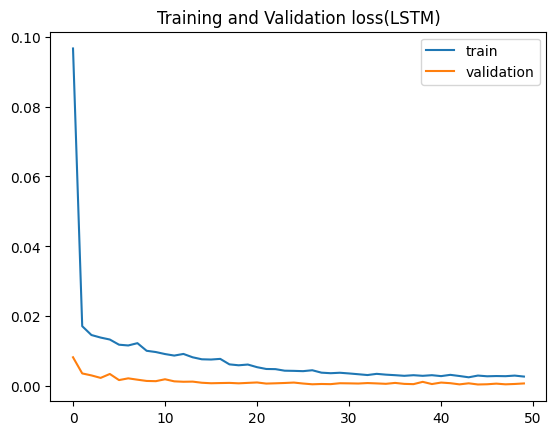

In [ ]:
LSTM_model = Sequential()

LSTM_model.add(Input(shape=(X_train.shape[1], 1)))
LSTM_model.add(LSTM(units=10, activation='tanh', return_sequences=True))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(units=20, activation = 'relu'))
LSTM_model.add(Dropout(0.3))

LSTM_model.add(Dense(units = 1))

print(LSTM_model.summary())

LSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = LSTM_model.fit(X_train, y_train, epochs=50, validation_split=0.2)
LSTM_model.save("LSTM_model_60.keras")

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title("Training and Validation loss(LSTM)")
plt.legend()
plt.show()

#### Inference

In [ ]:
init = X_test[0, :, 0]
LSTM_lookahead_output = lookahead_prediction(LSTM_model, init, lookahead_window)
LSTM_model_predict = LSTM_model.predict(X_test)
LSTM_model_predict = LSTM_model_predict.reshape(-1, 1)
LSTM_model_predict = LSTM_model_predict[:lookahead_window]
actual_val = y_test[:lookahead_window].reshape(-1, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train RMSE: 15.989669515203355
Test RMSE: 19.67707572165918


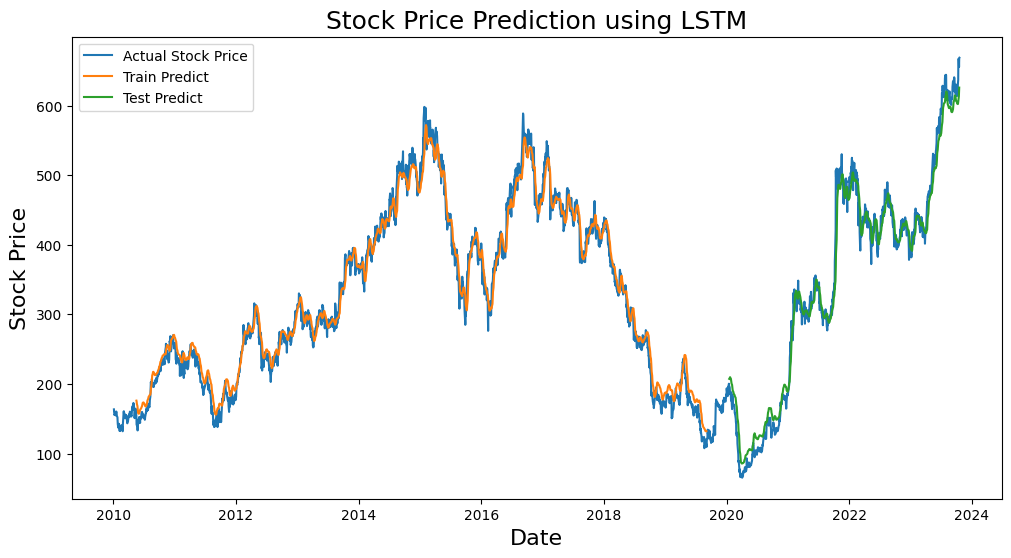

R2 score: 0.9848194063675554



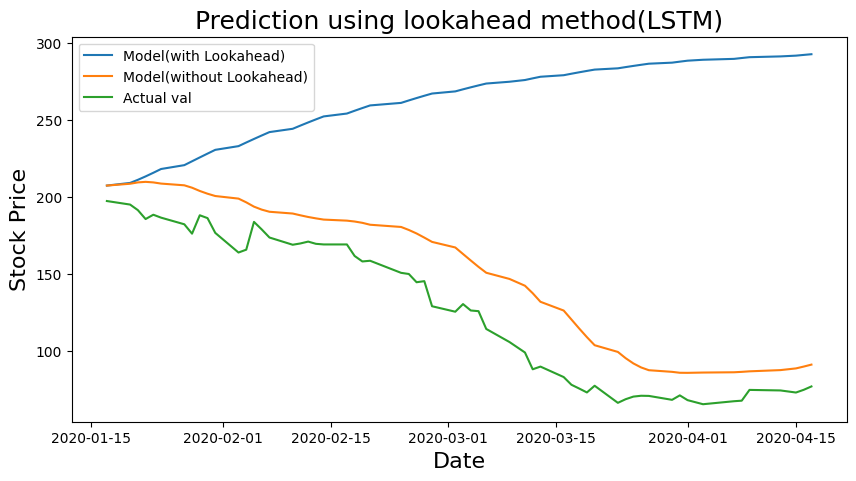

Ratio =  0.65


In [ ]:
train_predict = LSTM_model.predict(X_train)
test_predict = LSTM_model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

train_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train), train_predict.reshape(-1, 1)))
test_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_test), test_predict.reshape(-1, 1)))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback_window:len(train_predict)+lookback_window, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(lookback_window*2)+1:len(data_scaled)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(dates, scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(dates, trainPredictPlot, label='Train Predict')
plt.plot(dates, testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using LSTM', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.legend()
plt.savefig("StockPred_LSTM.png")
plt.show()

from sklearn.metrics import r2_score

# Actual values
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predicted values
predicted = test_predict

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)
print()

######################
# Lookahead prediction
######################

LSTM_lookahead_output = scaler.inverse_transform(LSTM_lookahead_output)
LSTM_model_predict = scaler.inverse_transform(LSTM_model_predict)
LSTM_actual_val = scaler.inverse_transform(actual_val)

plt.figure(figsize=(10, 5))
plt.plot(lookahead_dates, LSTM_lookahead_output, label='Model(with Lookahead)')
plt.plot(lookahead_dates, LSTM_model_predict, label='Model(without Lookahead)')
plt.plot(lookahead_dates, LSTM_actual_val, label='Actual val')
plt.title('Prediction using lookahead method(LSTM)', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.legend()
plt.savefig("WithLookAhead_LSTM.png")
plt.show()

deriv_actual_LSTM = Compute_trends(actual_val)
deriv_model_predict_LSTM = Compute_trends(LSTM_model_predict)

matches_LSTM = sum(1 for a, b in zip(deriv_actual_LSTM, deriv_model_predict_LSTM) if a == b)
print("Ratio = ", matches_LSTM/len(deriv_model_predict_LSTM))


### GRU model (upto training and inference)

#### Model Training

In [ ]:
  # GRU Model and Training
tf.keras.backend.clear_session()
GRU_model=Sequential()
GRU_model.add(GRU(16,return_sequences=True,input_shape=(lookback_window,1)))
GRU_model.add(GRU(16,return_sequences=True))
GRU_model.add(GRU(16))
GRU_model.add(Dropout(0.20))
GRU_model.add(Dense(1))
GRU_model.compile(loss='mean_squared_error',optimizer='adam')

GRU_model.summary()
GRU_history = GRU_model.fit(X_train,y_train,validation_split=0.2 ,epochs=50,batch_size=32,verbose=1, shuffle=False)
GRU_model.save("GRU_model_60.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 90, 16)              │             912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 90, 16)              │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 16)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,193 (16.38 KB)

 Trainable params: 4,193 (16.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 0.0275 - val_loss: 0.0504
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - loss: 0.0310 - val_loss: 0.0137
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0126 - val_loss: 0.0092
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0079 - val_loss: 0.0055
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.0024 - val_loss: 6.5158e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0023 - val_loss: 4.1277e-04
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━

In [ ]:
init = X_test[0, :, 0]
GRU_lookahead_output = lookahead_prediction(GRU_model, init, lookahead_window)
GRU_model_predict = GRU_model.predict(X_test)
GRU_model_predict = GRU_model_predict.reshape(-1, 1)
GRU_model_predict = GRU_model_predict[:lookahead_window]
actual_val = y_test[:lookahead_window].reshape(-1, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Train RMSE for GRU: 9.252646822723102
Test RMSE for GRU: 12.01899762893637


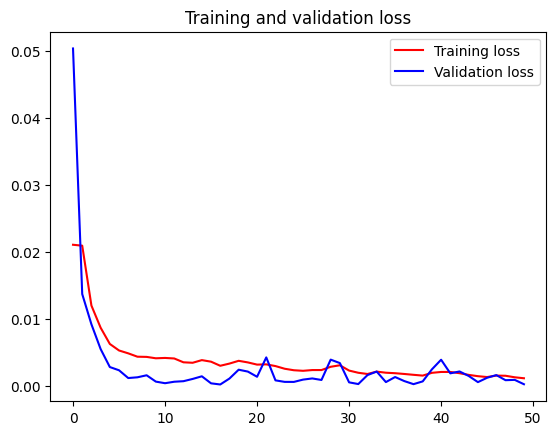

<Figure size 640x480 with 0 Axes>

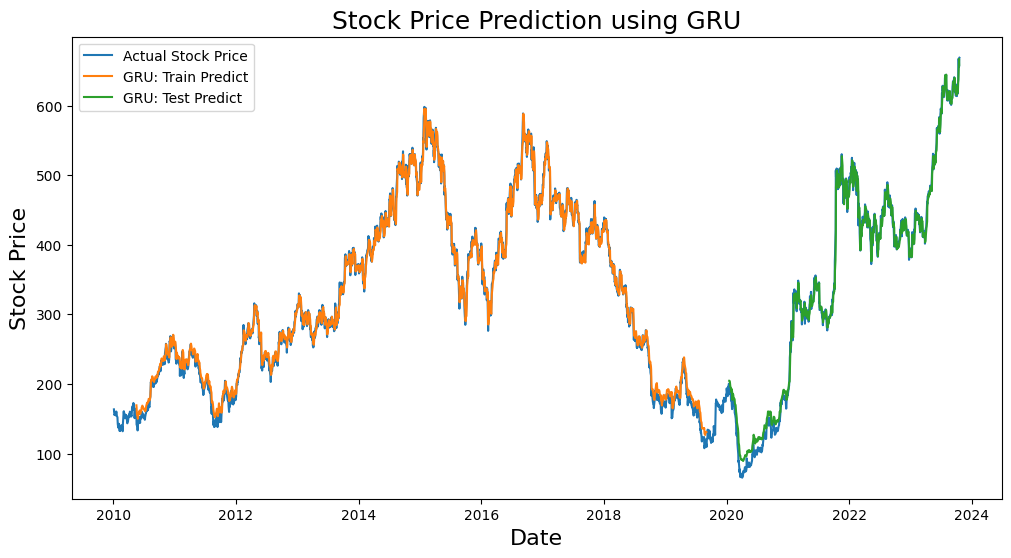

R2 score for GRU: 0.994336249153804



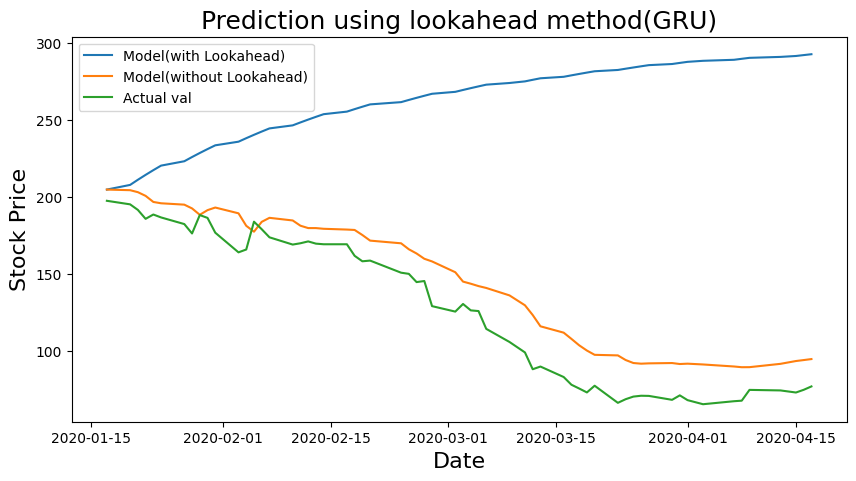

Ratio =  0.5666666666666667


In [ ]:
#
GRU_loss = GRU_history.history['loss']
GRU_val_loss = GRU_history.history['val_loss']

epochs = range(len(GRU_loss))

plt.plot(epochs, GRU_loss, 'r', label='Training loss')
plt.plot(epochs, GRU_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

GRU_train_predict=GRU_model.predict(X_train)
GRU_test_predict=GRU_model.predict(X_test)
GRU_train_predict.shape, GRU_test_predict.shape

GRU_train_predict = scaler.inverse_transform(GRU_train_predict)
GRU_test_predict = scaler.inverse_transform(GRU_test_predict)

GRU_train_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train), GRU_train_predict.reshape(-1, 1)))
GRU_test_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_test), GRU_test_predict.reshape(-1, 1)))
print(f"Train RMSE for GRU: {GRU_train_rmse}")
print(f"Test RMSE for GRU: {GRU_test_rmse}")

GRU_trainPredictPlot = np.empty_like(data_scaled)
GRU_trainPredictPlot[:, :] = np.nan
GRU_trainPredictPlot[lookback_window:len(GRU_train_predict)+lookback_window, :] =GRU_train_predict

# Shift test predictions for plotting
GRU_testPredictPlot = np.empty_like(data_scaled)
GRU_testPredictPlot[:, :] = np.nan
GRU_testPredictPlot[len(GRU_train_predict)+(lookback_window*2)+1:len(data_scaled)-1, :] = GRU_test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(dates, scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(dates, GRU_trainPredictPlot, label='GRU: Train Predict')
plt.plot(dates, GRU_testPredictPlot, label='GRU: Test Predict')
plt.title('Stock Price Prediction using GRU', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.legend()
plt.savefig("StockPred_GRU.png")

plt.show()

from sklearn.metrics import r2_score

# Actual values
GRU_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predicted values
GRU_predicted = GRU_test_predict

# Calculate the R2 score
GRU_r2 = r2_score(GRU_actual, GRU_predicted)

print("R2 score for GRU:", GRU_r2)
print()

######################
# Lookahead prediction
######################

lookahead_output = scaler.inverse_transform(GRU_lookahead_output)
model_predict = scaler.inverse_transform(GRU_model_predict)
actual_val = scaler.inverse_transform(actual_val)

plt.figure(figsize=(10, 5))
plt.plot(lookahead_dates, lookahead_output, label='Model(with Lookahead)')
plt.plot(lookahead_dates, model_predict, label='Model(without Lookahead)')
plt.plot(lookahead_dates, actual_val, label='Actual val')
plt.title('Prediction using lookahead method(GRU)', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.legend()
plt.savefig("WithLookAhead_GRU.png")

plt.show()

deriv_actual_GRU = Compute_trends(actual_val)
deriv_model_predict_GRU = Compute_trends(model_predict)

matches_GRU = sum(1 for a, b in zip(deriv_actual_GRU, deriv_model_predict_GRU) if a == b)
print("Ratio = ", matches_GRU/len(deriv_model_predict_GRU))

### Transformer model

#### Model training

In [ ]:
# Reshape input for the model
X_train_transformer = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_transformer = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train_transformer.shape[1], X_train_transformer.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

Transformer_model = Model(inputs=inputs, outputs=outputs)
Transformer_model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
Transformer_model.summary()

# Train the model
history = Transformer_model.fit(X_train_transformer, y_train, validation_split=0.2, epochs=50, batch_size=64, verbose=1)
Transformer_model.save("Transformer_model_60.keras")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 90, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 90, 1)          │              2 │ input_layer_1[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 90, 1)          │          7,169 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 90, 1)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 90, 1)          │              0 │ dropout_2[0][0],       │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 90, 1)          │              2 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 90, 4)          │              8 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 90, 4)          │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 90, 1)          │              5 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 90, 1)          │              0 │ dense_2[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 90)             │              0 │ add_1[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 90)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 20)             │          1,820 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             21 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,027 (35.26 KB)

 Trainable params: 9,027 (35.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 489ms/step - loss: 0.1010 - val_loss: 0.0070
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 492ms/step - loss: 0.0307 - val_loss: 0.0046
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 517ms/step - loss: 0.0209 - val_loss: 0.0021
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 489ms/step - loss: 0.0155 - val_loss: 0.0013
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 479ms/step - loss: 0.0133 - val_loss: 0.0017
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 483ms/step - loss: 0.0113 - val_loss: 9.7128e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step - loss: 0.0105 - val_loss: 0.0011
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - loss: 0.0096 - val_loss: 9.3488e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 491ms/step - loss: 0.0094 - val_loss: 0.0010
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 489ms/step - loss: 0.0079 - val_loss: 8.7922e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - loss: 0.0068 - val_loss: 8.1346e-04
Epoch 12/50
29/29 ━━━━━━━

#### Model Inference

In [ ]:
init = X_test[0, :, 0]
Transformer_lookahead_output = lookahead_prediction(Transformer_model, init, lookahead_window)
Transformer_model_predict = Transformer_model.predict(X_test)
Transformer_model_predict = model_predict.reshape(-1, 1)
Transformer_model_predict = model_predict[:lookahead_window]
actual_val = y_test[:lookahead_window].reshape(-1, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

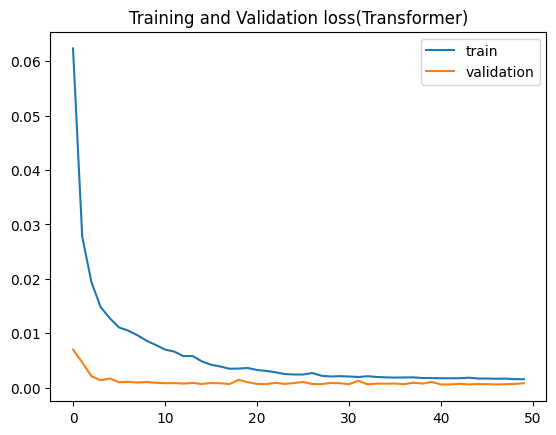

72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
Train RMSE: 17.370127575004688
Test RMSE: 29.662960971503253


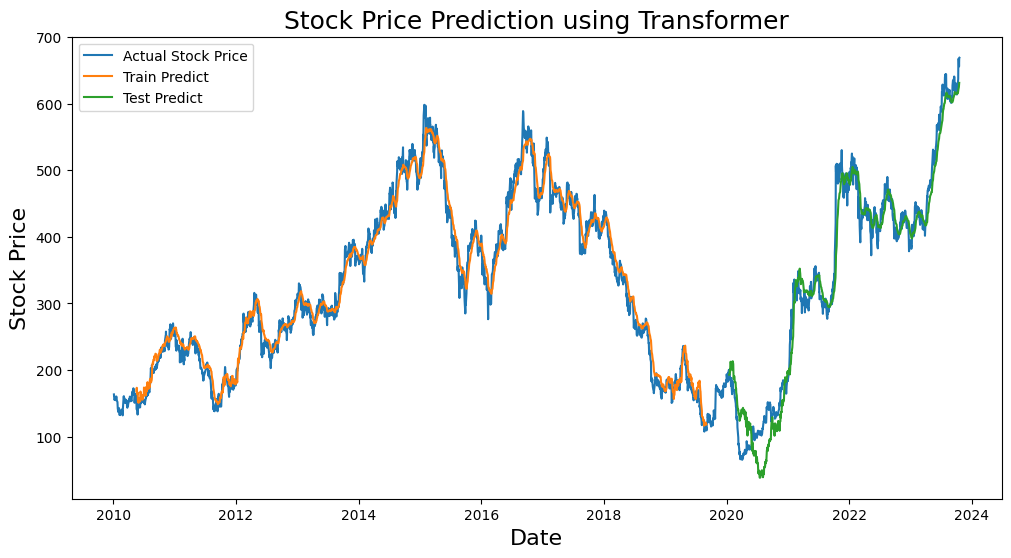

R2 score: 0.9655017836260789



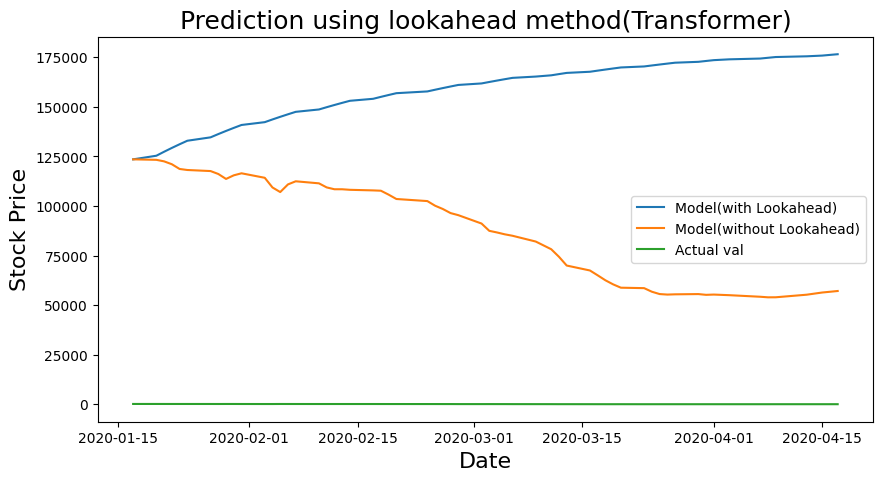

Ratio =  0.5666666666666667


In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.title("Training and Validation loss(Transformer)")
plt.legend()
plt.show()

# Make predictions
train_predict = Transformer_model.predict(X_train_transformer)
test_predict = Transformer_model.predict(X_test_transformer)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

train_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train), train_predict.reshape(-1, 1)))
test_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_test), test_predict.reshape(-1, 1)))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback_window:len(train_predict)+lookback_window, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(lookback_window*2)+1:len(data_scaled)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(dates, scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(dates, trainPredictPlot, label='Train Predict')
plt.plot(dates, testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.legend()
plt.savefig("StockPred_Transformer.png")
plt.show()

# R2 score
actual = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted = test_predict

r2 = r2_score(actual, predicted)
print("R2 score:", r2)
print()

######################
# Lookahead prediction
######################

lookahead_output = scaler.inverse_transform(lookahead_output)
model_predict = scaler.inverse_transform(model_predict)
actual_val = scaler.inverse_transform(actual_val)

plt.figure(figsize=(10, 5))
plt.plot(lookahead_dates, lookahead_output, label='Model(with Lookahead)')
plt.plot(lookahead_dates, model_predict, label='Model(without Lookahead)')
plt.plot(lookahead_dates, actual_val, label='Actual val')
plt.title('Prediction using lookahead method(Transformer)', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.legend()
plt.savefig("WithLookAhead_Transformer.png")

plt.show()

deriv_actual_Transformer = Compute_trends(actual_val)
deriv_model_predict_Transformer = Compute_trends(model_predict)

matches_Transformer = sum(1 for a, b in zip(deriv_actual_Transformer, deriv_model_predict_Transformer) if a == b)
print("Ratio = ", matches_Transformer/len(deriv_model_predict_Transformer))

### Hybrid model (upto training and inference)

In [ ]:
tf.keras.backend.clear_session()
hybrid_model = Sequential()

hybrid_model.add(Input(shape=(X_train.shape[1], 1)))

hybrid_model.add(LSTM(units=10, activation='tanh', return_sequences=True))
hybrid_model.add(Dropout(0.2))

hybrid_model.add(LSTM(units = 20, activation = 'tanh', return_sequences=True))
hybrid_model.add(Dropout(0.3))

hybrid_model.add(tf.keras.layers.GRU(10,return_sequences=False))
hybrid_model.add(tf.keras.layers.Dropout(.2,))

hybrid_model.add(Dense(units = 1))

In [ ]:
hybrid_model.summary()

#Train the model with validation data
hybrid_model.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
history = hybrid_model.fit(X_train, y_train, epochs=50, validation_split=0.2)
hybrid_model.save("Hybrid_model_60.keras")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 10)              │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 90, 20)              │           2,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 90, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 10)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,931 (15.36 KB)

 Trainable params: 3,931 (15.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.1429 - val_loss: 0.0099
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.0146 - val_loss: 0.0015
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0101 - val_loss: 0.0016
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.0096 - val_loss: 0.0013
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0088 - val_loss: 0.0012
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0079 - val_loss: 0.0012
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0082 - val_loss: 0.0024
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0074 - val_loss: 9.4289e-04
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.0069 - val_loss: 8.1688e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 0.0068 - val_loss: 0.0012
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s

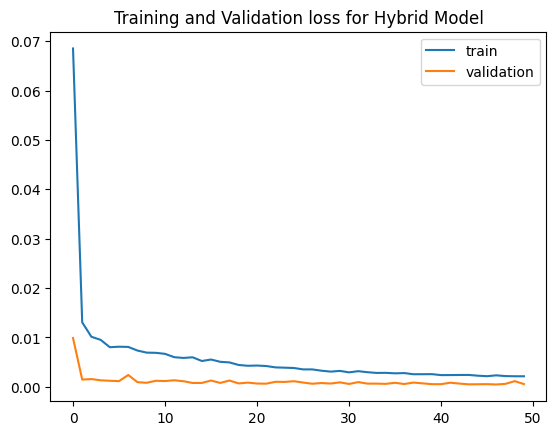

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.title("Training and Validation loss for Hybrid Model")
plt.legend()

In [ ]:
init = X_test[0, :, 0]
lookahead_output = lookahead_prediction(hybrid_model, init, lookahead_window)
model_predict = hybrid_model.predict(X_test)
model_predict = model_predict.reshape(-1, 1)
model_predict = model_predict[:lookahead_window]
actual_val = y_test[:lookahead_window].reshape(-1, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Train RMSE: 16.414907360024934
Test RMSE: 21.222566365948584


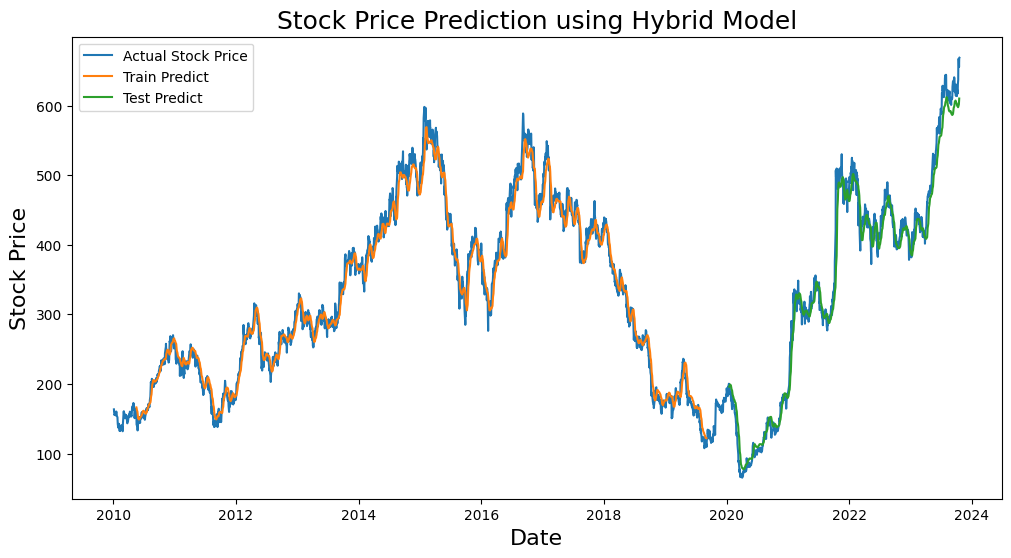

R2 score: 0.9823411083528896



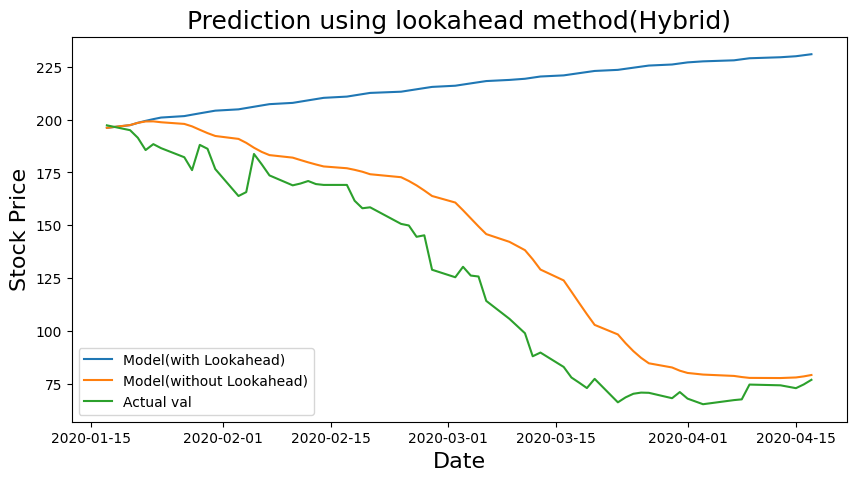

Ratio =  0.65


In [ ]:
train_predict = hybrid_model.predict(X_train)
test_predict = hybrid_model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

train_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train), train_predict.reshape(-1, 1)))
test_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_test), test_predict.reshape(-1, 1)))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback_window:len(train_predict)+lookback_window, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(lookback_window*2)+1:len(data_scaled)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(dates, scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(dates, trainPredictPlot, label='Train Predict')
plt.plot(dates, testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Hybrid Model', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.legend()
plt.savefig("StockPred_Hybrid.png")

plt.show()

from sklearn.metrics import r2_score

# Actual values
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predicted values
predicted = test_predict

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)
print()

######################
# Lookahead prediction
######################

lookahead_output = scaler.inverse_transform(lookahead_output)
model_predict = scaler.inverse_transform(model_predict)
actual_val = scaler.inverse_transform(actual_val)

plt.figure(figsize=(10, 5))
plt.plot(lookahead_dates, lookahead_output, label='Model(with Lookahead)')
plt.plot(lookahead_dates, model_predict, label='Model(without Lookahead)')
plt.plot(lookahead_dates, actual_val, label='Actual val')
plt.title('Prediction using lookahead method(Hybrid)', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.legend()
plt.savefig("WithLookAhead_Hybrid.png")

plt.show()

deriv_actual_Hybrid = Compute_trends(actual_val)
deriv_model_predict_Hybrid = Compute_trends(model_predict)

matches_Hybrid = sum(1 for a, b in zip(deriv_actual_Hybrid, deriv_model_predict_Hybrid) if a == b)
print("Ratio = ", matches_Hybrid/len(deriv_model_predict_Hybrid))

In [ ]:
# Example prediction arrays from your 4 models
gru_predictions = deriv_model_predict_GRU  # Replace with actual predictions
lstm_predictions = deriv_model_predict_LSTM
transformer_predictions = deriv_model_predict_Transformer
hybrid_predictions = deriv_model_predict_Hybrid

weights = np.array([matches_GRU/len(deriv_model_predict_GRU), matches_LSTM/len(deriv_model_predict_LSTM), matches_Transformer/len(deriv_model_predict_Transformer), matches_Hybrid/len(deriv_model_predict_Hybrid)])
weights = weights/np.sum(weights)
# Stack predictions vertically (models as rows, days as columns)
all_predictions = np.array([gru_predictions, lstm_predictions, transformer_predictions, hybrid_predictions])
# print(all_predictions.shape)

# For each prediction (across models), perform weighted majority voting
final_predictions = []
for i in range(all_predictions.shape[1]):  # Iterate over each prediction for each time step

    if all_predictions[:, i].any():
      weighted_sum = np.dot(weights, all_predictions[:, i])

    # If the weighted sum is positive, the final prediction is 1, else -1
    final_predictions.append(np.sign(weighted_sum))

final_predictions = np.array(final_predictions)

# Print the final weighted bagged predictions
matches_bagging = sum(1 for a, b in zip(deriv_actual_Hybrid, final_predictions) if a == b)
print("Ratio = ", matches_bagging/len(deriv_model_predict_Hybrid))

Ratio =  0.6166666666666667
